1. Ensure you have data structured longitudinally i.e. for each person, have the FEV1 and O2 data as time series.
2. Then run the current ‘point in time model’ (FEV1 only) for each FEV1 measurement for a person.
3. Produce a visualisation of the output of the model which shows all time point at once e.g. have time on the x-axis and some display of the uncertain distributions of the latent variables on the y axis. Could be sideways bar charts or box plots or whatever looks best.
4. Then we need to make a longitudinal model which has all data points at once for an individual. The simplest way to do this is to separate out the lung damage and airway blockage variables (as we always intended) and have **one** lung damage variable shared across all time points. This represents the assumption that lung damage is constant at this time scale. Then have separate blockage variables for each time point. Try to get this model running if you can + update your visualisation to include the extra lung damage latent variable.

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../data/")

import O2_FEV1_df
import model_lung_health
import biology as bio

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plotsdir = "../../../../PlotsSmartcare/longitudinal_model/"

In [2]:
O2_FEV1 = O2_FEV1_df.create()



** Loading measurements data **

* Dropping unnecessary columns from measurements data *
Columns filtered ['User ID', 'UserName', 'Recording Type', 'Date/Time recorded', 'FEV 1', 'Weight in Kg', 'O2 Saturation', 'Pulse (BPM)', 'Rating', 'Temp (deg C)']
Dropping columns {'FEV 10', 'FEV 1 %', 'Activity - Points', 'Sputum sample taken?', 'Calories', 'Predicted FEV', 'Activity - Steps'}

* Renaming columns *
Renamed columns {'Date/Time recorded': 'Date recorded', 'FEV 1': 'FEV1', 'Weight in Kg': 'Weight (kg)'}


/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/milestone_model/../data/measurements_data.py:101: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "mydata.csv")



* Applying data sanity checks *

FEV1
Dropping 1 entries with FEV1 = 3.45 for user Kings004

Weight (kg)
Dropping 2 entries with Weight (kg) = 6.0 for user Papworth033
Dropping 1 entries with Weight (kg) = 0.55 for user Kings013
Dropping 1 entries with Weight (kg) = 8.262500000000001 for user Papworth017
Dropping 1 entries with Weight (kg) = 1056.0 for user leeds01730
Dropping 1 entries with Weight (kg) = 20.0 for user Papworth019
Warning - ID PapworthSummer has Weight (28.9375) outside 30-122 kg range
Warning - ID PapworthSummer has Weight (29.200000000000003) outside 30-122 kg range
Warning - ID EmemTest has Weight (14.9625) outside 30-122 kg range
Warning - ID FPH0011 has Weight (7.8) outside 30-122 kg range

Pulse (BPM)
Dropping 14 entries with Pulse (BPM) == 511)
       Pulse (BPM)      UserName
60638        511.0   Papworth002
60989        511.0   Papworth001
61026        511.0    leeds01050
61374        511.0    leeds01320
63126        511.0      Kings005
63525        511.0    

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/milestone_model/../data/patient_data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Height.loc[df.ID == "60"] = tmp * 100
/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():



* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Comments', 'Remote Monitoring App User ID', 'Unable Sputum Samples', 'Hospital', 'Inconvenience Payment', 'Date Last PE Start', 'Less Exacerbation', 'Age 18 Years', 'Unable Informed Consent', 'Genetic Testing', 'Sputum Samples', 'GP Letter Sent', 'Informed Consent', 'Telemetric Measures', 'Transplant Recipients', 'Freezer Required', 'Date Consent Obtained', 'Date Last PE Stop', 'Pulmonary Exacerbation', 'Study Email', 'CFQR Quest Comp', 'Study Number'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)

** Loading antibiotics data **

* Dropping un

In [3]:
# Settings
set_age = 33
set_height = 165
set_sex = "Male"
FEV1 = bio.calc_predicted_fev1(set_height, set_age, set_sex)
pred_FEV1 = FEV1["Predicted FEV1"]
pred_FEV1_std = FEV1["std"]

# healthy_FEV1_prior={"type":"uniform"}
healthy_FEV1_prior = {"type": "gaussian", "mu": pred_FEV1, "sigma": pred_FEV1_std}

inference, FEV1, HFEV1, _prior_HFEV1, AB, _prior_ab = model_lung_health.build_healthy(
    healthy_FEV1_prior
)

1.0
n_decimals 1
0.0
n_decimals 2
0.1
n_decimals 1
calculating cpt of shape 59 x 50 x 16 (C x (A x B)) 


/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_83102/2933779174.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


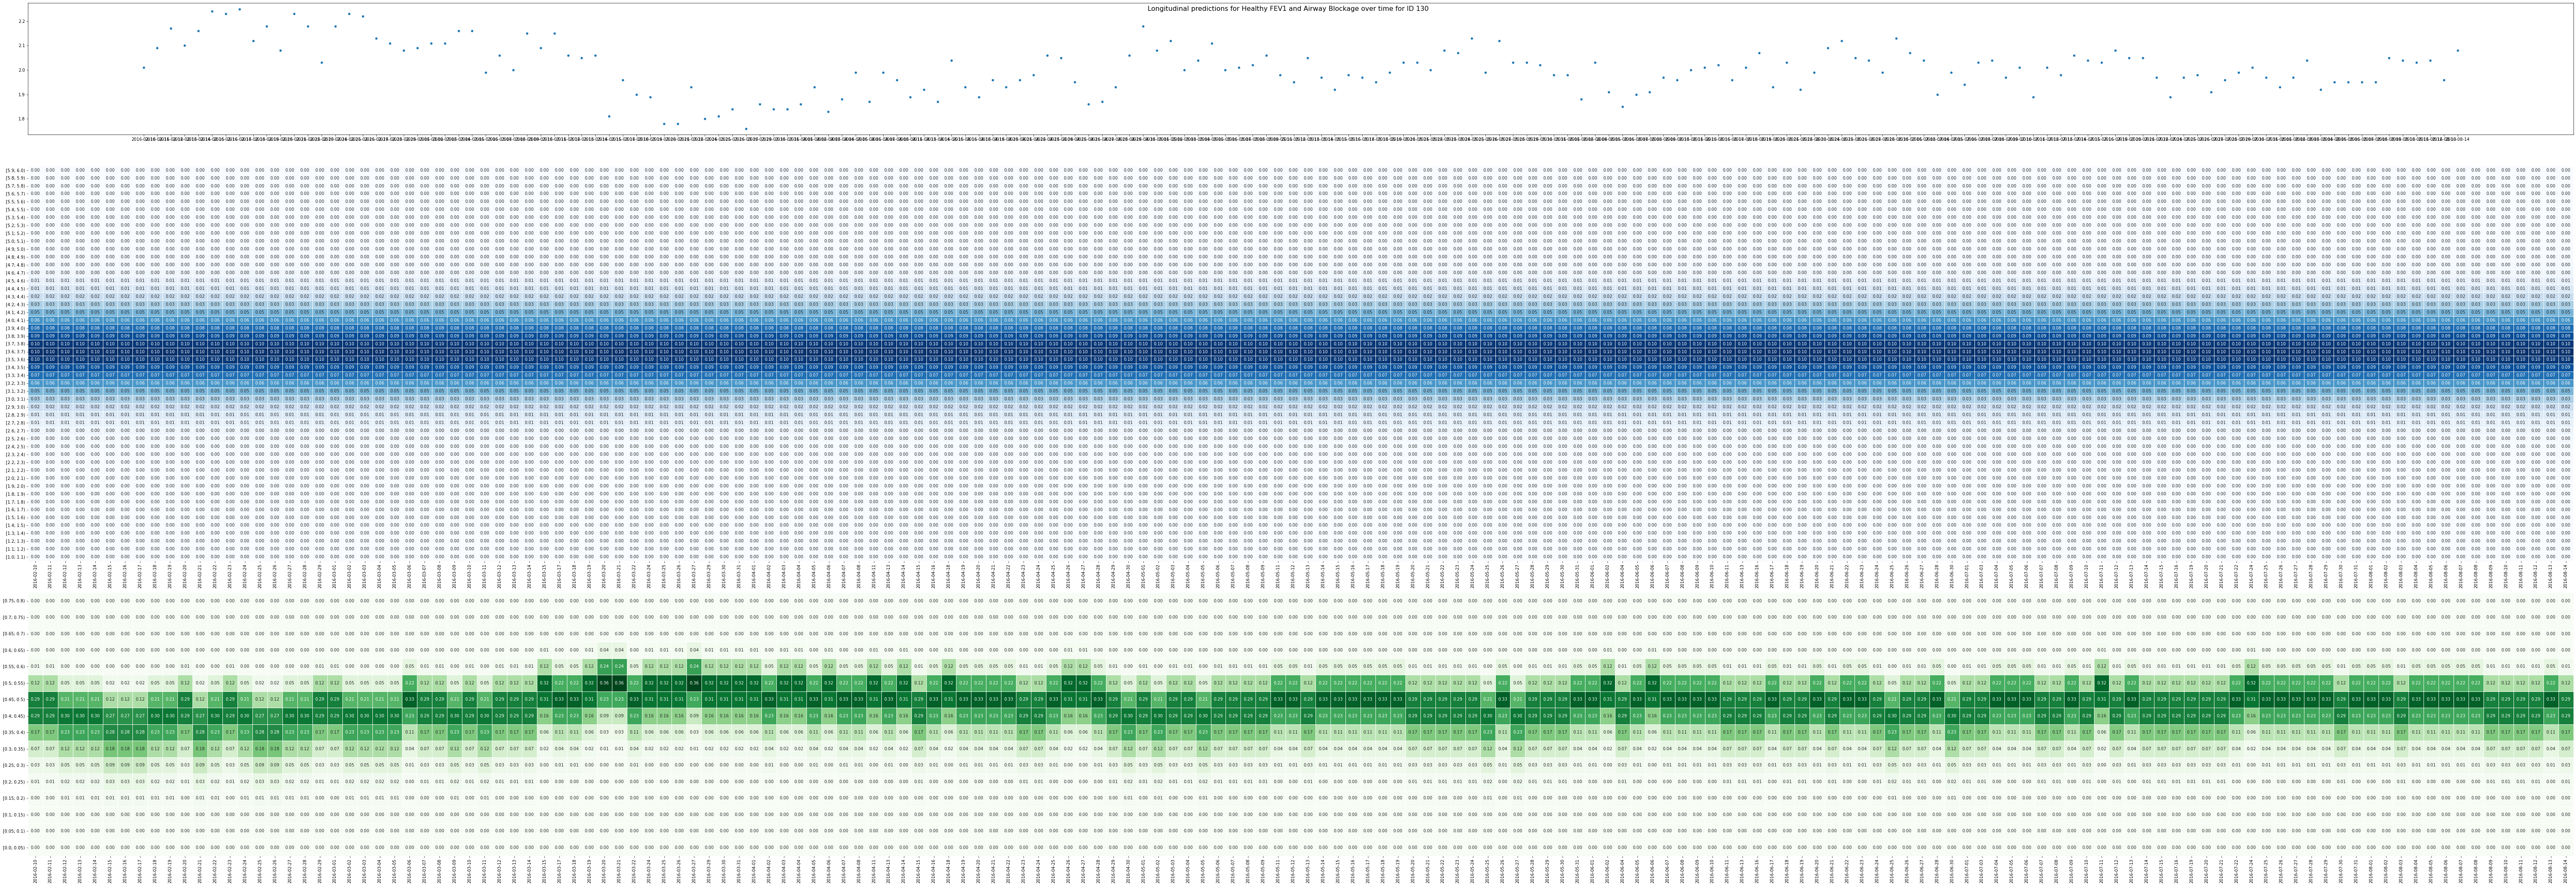

In [17]:
for id in ["130"]: #O2_FEV1.ID.unique()[0:50]:
    df_for_ID = O2_FEV1[O2_FEV1.ID == id]
    fev1 = df_for_ID.FEV1.values
    days = df_for_ID["Date recorded"].astype(str).values
    days_with_fev1 = [f"{days[i]} ({fev1[i]} L)" for i in range(len(days))]

    # Create empty dataframe of with HFEV1.bins as index name, and days as column names
    hfev1_df = pd.DataFrame(index=HFEV1.bins_str, columns=days)
    ab_df = pd.DataFrame(index=AB.bins_str, columns=days)

    for i in range(len(fev1)):
        res_hfev1 = model_lung_health.infer(inference, [HFEV1], [[FEV1, fev1[i]]])
        res_ab = model_lung_health.infer(inference, [AB], [[FEV1, fev1[i]]])
        hfev1_df[days[i]] = res_hfev1.values
        ab_df[days[i]] = res_ab.values

    # Create heatmap using sns with hfev1_df index on x, columns on y, coloured by values
    title = f"Longitudinal predictions for Healthy FEV1 and Airway Blockage over time for ID {id}"

    fig, axs = plt.subplots(
        3, 1, figsize=(len(fev1) * 0.5 + 1, 30), gridspec_kw={"height_ratios": [1, 3, 2]}
    )

    fig.suptitle(title, fontsize=16)
    sns.scatterplot(x=days, y=fev1, ax=axs[0])

    # Order hfev1_df by index descending
    hfev1_df = hfev1_df.reindex(index=hfev1_df.index[::-1])
    ab_df = ab_df.reindex(index=ab_df.index[::-1])

    # Add heatmap on bottom plot
    sns.heatmap(
        hfev1_df,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        ax=axs[1],
        cbar=False,
    )

    sns.heatmap(
        ab_df,
        cmap="Greens",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        ax=axs[2],
        cbar=False,
    )

    plt.tight_layout()
    # plt.savefig(f"{plotsdir}{title}.png")
    # plt.close()